In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

# Introduction to Spark

## Basic initialization

`SparkSession` is used to connect to the Spark Cluster.

In [3]:
from pyspark.sql import SparkSession

We will use Pandas to operate on the reduced data in the *driver program*.

In [17]:
!pip install --upgrade pandas
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Numpy will be always useful.

In [5]:
import numpy as np

Create a new session (or reuse an existing one).

In [14]:
spark = SparkSession.builder.getOrCreate()

In [15]:
spark

We can see that the session is established.

## Creating Spark Data Frames from Pandas

We can list the tables in our Spark Session, currently empty.

In [9]:
# spark trzyma ramki danych w postaci katalogu
print(spark.catalog.listTables())

[]


We can create a Pandas `DataFrame` with random values.

In [18]:
pd_temp = pd.DataFrame(np.random.random(100))

We can see on the plot that it is really random:

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

<Axes: >

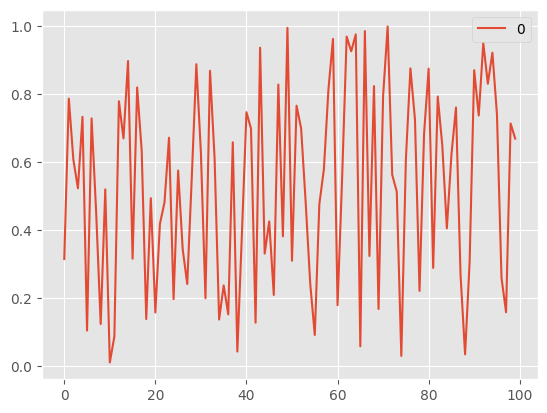

In [19]:
pd_temp.plot()

Now we can convert it into Spark DataFrame:

In [22]:
# Ta linia jest potrzeba, bo był problem z metodą iteritems w wersji pandas 2.2.3
pd.DataFrame.iteritems = pd.DataFrame.items

# pandasowa tabela jest zamieniana na sparkową
spark_temp = spark.createDataFrame(pd_temp)

`createOrReplaceTempView` creates (or replaces if that view name already exists) a lazily evaluated "view" that you can then use like a table in Spark SQL.

It does not persist to memory unless you cache (persist) the dataset that underpins the view.

In [24]:
# żeby można było na tabeli sparkowej wykonywać operacje, to musimy utworzyć na niej widok
spark_temp.createOrReplaceTempView("temp")

The created view is `TEMPORARY` which means it is not persistent.

In [26]:
# tableType = 'TEMPORARY' oznacza, że widok nie jest nigdzie zapisany
print(spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [27]:
spark_temp.show()

+--------------------+
|                   0|
+--------------------+
| 0.31568793924344274|
|  0.7875304869845408|
|   0.607893142872716|
|  0.5238292831164434|
|  0.7339819791485863|
|  0.1051734107121185|
|  0.7293695902465654|
|  0.4538087421863899|
|  0.1244890263242121|
|  0.5207050888369191|
|0.011372899008149417|
| 0.08772755356511552|
|  0.7798675862729844|
|  0.6706396936240835|
|  0.8981749733905986|
|  0.3166373849857247|
|  0.8205897824899049|
|  0.6338091884793905|
|  0.1391929785996887|
| 0.49467051550733443|
+--------------------+
only showing top 20 rows



We can now use transformations on this DataFrame. The transformations are translated (compiled) to RDD transformations.

In [28]:
from pyspark.sql.functions import col, asc

In [29]:
# przefiltrować wiersze w kolumnie '0', żeby wartość była większa od 0.9
spark_temp.filter((col('0') > 0.9)).show()

+------------------+
|                 0|
+------------------+
|0.9373853210765574|
| 0.995985693373938|
|0.9633372874924812|
|0.9700623943850931|
|0.9268259884255332|
|0.9764306749152682|
|0.9862534093669468|
|  0.99988544397729|
|0.9507035982728421|
|0.9228822581799161|
+------------------+



## Creating Spark Data Frames from input files

In [35]:
file_path = "airports.csv"

# Read in the airports data
airports = spark.read.csv(file_path,header=True)

# Show the data
print(airports.show())

+----+--------------------+--------------+----------------+-------+--------+------------------+
|CODE|             AIRPORT|          CITY|           STATE|COUNTRY|LATITUDE|         LONGITUDE|
+----+--------------------+--------------+----------------+-------+--------+------------------+
|   1|      Goroka Airport|        Goroka|Papua New Guinea|    GKA|    AYGA|-6.081689834590001|
|   2|      Madang Airport|        Madang|Papua New Guinea|    MAG|    AYMD|    -5.20707988739|
|   3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea|    HGU|    AYMH|-5.826789855957031|
|   4|      Nadzab Airport|        Nadzab|Papua New Guinea|    LAE|    AYNZ|         -6.569803|
|   5|Port Moresby Jack...|  Port Moresby|Papua New Guinea|    POM|    AYPY|-9.443380355834961|
|   6|Wewak Internation...|         Wewak|Papua New Guinea|    WWK|    AYWK|    -3.58383011818|
|   7|  Narsarsuaq Airport|  Narssarssuaq|       Greenland|    UAK|    BGBW|     61.1604995728|
|   8|Godthaab / Nuuk A...|      Godthaa

It may be useful to convert them to Pandas for quick browsing.

**Warning!** This is not efficient for large datasets, as it requires performing actions on the dataset.

In [37]:
# opracja konwersji do pandas konwertuje całą tabelę i próbuję wczytać do paimęci drivera, więc dla dużych tabel to nie ma sensu, ale po przefiltrowaniu ma sens
airports.toPandas()


,CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689834590001
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20707988739
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789855957031
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380355834961
...,...,...,...,...,...,...,...
7179,12053,Rugao Air Base,Rugao,China,RUG,ZSRG,32.25788497924805
7180,12054,Wuhu Air Base,Wuhu,China,WHU,ZSWU,31.3906
7181,12055,Shanshan Airport,Shanshan,China,SXJ,ZWSS,42.91170120239258
7182,12056,Yingkou Lanqi Airport,Yingkou,China,YKH,ZYYK,40.542524


### Running SQL queries on dataframes

In [40]:
# Zawsze musimy tworzyć widok jeśli chcemy przetwarzać dane w ramce sparkowej
airports.createOrReplaceTempView("airports")

In [41]:
# Get the first 10 rows of flights
query = "FROM airports SELECT * LIMIT 10"

airports10 = spark.sql(query)

# Show the results
airports10.show()

+----+--------------------+------------+----------------+-------+--------+------------------+
|CODE|             AIRPORT|        CITY|           STATE|COUNTRY|LATITUDE|         LONGITUDE|
+----+--------------------+------------+----------------+-------+--------+------------------+
|   1|      Goroka Airport|      Goroka|Papua New Guinea|    GKA|    AYGA|-6.081689834590001|
|   2|      Madang Airport|      Madang|Papua New Guinea|    MAG|    AYMD|    -5.20707988739|
|   3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea|    HGU|    AYMH|-5.826789855957031|
|   4|      Nadzab Airport|      Nadzab|Papua New Guinea|    LAE|    AYNZ|         -6.569803|
|   5|Port Moresby Jack...|Port Moresby|Papua New Guinea|    POM|    AYPY|-9.443380355834961|
|   6|Wewak Internation...|       Wewak|Papua New Guinea|    WWK|    AYWK|    -3.58383011818|
|   7|  Narsarsuaq Airport|Narssarssuaq|       Greenland|    UAK|    BGBW|     61.1604995728|
|   8|Godthaab / Nuuk A...|    Godthaab|       Greenland|   

### More complex examples

Read data from CSV file:
 * `inferSchema` - to detect which columns are numbers (not strigs!) - useful e.g. for sorting.
 * `header` - to read the firs line as column names

In [79]:
# Wczytywanie plików z użyciem inferencji schematu danych,
# to jest po to żeby zgadnąć schemat
countries = spark.read.csv("countries of the world.csv",inferSchema=True,header=True)

In [80]:
countries.toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


We can inspect the schema of the DataFrame.

In [44]:
countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



### Examples of SQL Queries

In [81]:
countries.createOrReplaceTempView("countries")

In [50]:
spark.sql("SELECT * FROM countries WHERE Region LIKE '%OCEANIA%'").toPandas().head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
1,Australia,OCEANIA,20264082,7686850,"2,6","0,34","3,98","4,69",29000,"100,0","565,5","6,55","0,04","93,41",1,"12,14","7,51","0,038","0,262","0,7"
2,Cook Islands,OCEANIA,21388,240,"89,1","50,00",None,None,5000,"95,0","289,9","17,39","13,04","69,57",2,21,None,"0,151","0,096","0,753"
3,Fiji,OCEANIA,905949,18270,"49,6","6,18","-3,14","12,62",5800,"93,7","112,6","10,95","4,65","84,4",2,"22,55","5,65","0,089","0,135","0,776"
4,French Polynesia,OCEANIA,274578,4167,"65,9","60,60","2,94","8,44",17500,"98,0","194,5","0,82","5,46","93,72",2,"16,68","4,69","0,031","0,19","0,769"


### Queries using PySpark DSL

DSL = Domain Specific Language - API similar to natural or other language, implemented as library in another language.

List all the countries with the population > 38 million

In [51]:
countries.filter((col("Population") > 38000000)).orderBy("Population").toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Poland,EASTERN EUROPE,38536869,312685,"123,3","0,16","-0,49","8,51",11100,"99,8","306,3","45,91","1,12","52,97",3,"9,85","9,89","0,05","0,311","0,64"
1,Argentina,LATIN AMER. & CARIB,39921833,2766890,"14,4","0,18","0,61","15,18",11200,"97,1","220,4","12,31","0,48","87,21",3,"16,73","7,55","0,095","0,358","0,547"
2,Spain,WESTERN EUROPE,40397842,504782,"80,0","0,98","0,99","4,42",22000,"97,9","453,5","26,07","9,87","64,06",3,"10,06","9,72","0,04","0,295","0,665"
3,Sudan,SUB-SAHARAN AFRICA,41236378,2505810,"16,5","0,03","-0,02","62,5",1900,"61,1","16,3","6,83","0,18","92,99",2,"34,53","8,97","0,387","0,203","0,41"
4,Colombia,LATIN AMER. & CARIB,43593035,1138910,"38,3","0,28","-0,31","20,97",6300,"92,5","176,2","2,42","1,67","95,91",2,"20,48","5,58","0,125","0,342","0,533"
5,South Africa,SUB-SAHARAN AFRICA,44187637,1219912,"36,2","0,23","-0,29","61,81",10700,"86,4","107,0","12,08","0,79","87,13",1,"18,2",22,"0,025","0,303","0,671"
6,Ukraine,C.W. OF IND. STATES,46710816,603700,"77,4","0,46","-0,39","20,34",5400,"99,7","259,9","56,21","1,61","42,18",3,"8,82","14,39","0,187","0,452","0,361"
7,Burma,ASIA (EX. NEAR EAST),47382633,678500,"69,8","0,28","-1,8","67,24",1800,"85,3","10,1","15,19","0,97","83,84",2,"17,91","9,83","0,564","0,082","0,353"
8,"Korea, South",ASIA (EX. NEAR EAST),48846823,98480,"496,0","2,45",0,"7,05",17800,"97,9","486,1","17,18","1,95","80,87",3,10,"5,85","0,033","0,403","0,563"
9,Italy,WESTERN EUROPE,58133509,301230,"193,0","2,52","2,07","5,94",26700,"98,6","430,9","27,79","9,53","62,68",None,"8,72","10,4","0,021","0,291","0,688"


Select all the countries from Europe

In [52]:
countries.select("Country", "Population").where(col("Region").like("%EUROPE%")).show()

+--------------------+----------+
|             Country|Population|
+--------------------+----------+
|            Albania |   3581655|
|            Andorra |     71201|
|            Austria |   8192880|
|            Belgium |  10379067|
|Bosnia & Herzegov...|   4498976|
|           Bulgaria |   7385367|
|            Croatia |   4494749|
|     Czech Republic |  10235455|
|            Denmark |   5450661|
|      Faroe Islands |     47246|
|            Finland |   5231372|
|             France |  60876136|
|            Germany |  82422299|
|          Gibraltar |     27928|
|             Greece |  10688058|
|           Guernsey |     65409|
|            Hungary |   9981334|
|            Iceland |    299388|
|            Ireland |   4062235|
|        Isle of Man |     75441|
+--------------------+----------+
only showing top 20 rows



Conditions in `where` clause can contain logical expressions.

In [53]:
countries.select("Country", "Population")\
.where((col("Region").like("%EUROPE%")) & (col("Population")> 10000000)).show()

+---------------+----------+
|        Country|Population|
+---------------+----------+
|       Belgium |  10379067|
|Czech Republic |  10235455|
|        France |  60876136|
|       Germany |  82422299|
|        Greece |  10688058|
|         Italy |  58133509|
|   Netherlands |  16491461|
|        Poland |  38536869|
|      Portugal |  10605870|
|       Romania |  22303552|
|         Spain |  40397842|
|United Kingdom |  60609153|
+---------------+----------+



### Aggregation

We can run aggregations with predefined functions (faster!):

In [54]:
from pyspark.sql.functions import sum

In [56]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population")).toPandas()

In [57]:
pd_countries

,Region,sum(Population)
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


We can make the column name look better, by using `alias`:

In [58]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population").alias('Total')).toPandas()

In [59]:
pd_countries

,Region,Total
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


### Plot examples
Pandas DataFrames are useful for plotting using MatPlotLib:

<Axes: xlabel='Region'>

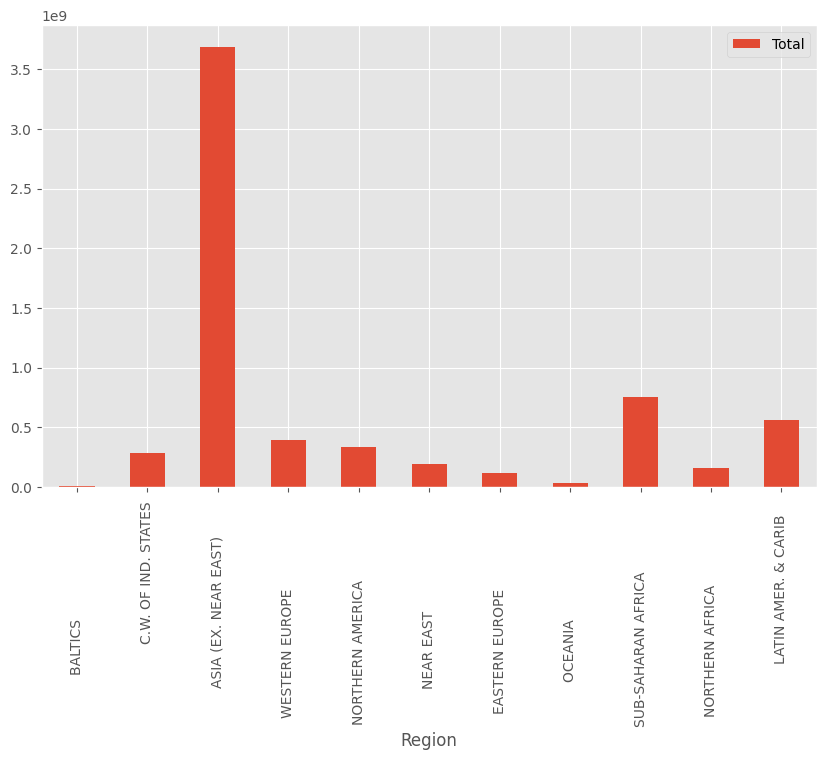

In [60]:
# Użyteczne jest używanie pandas dataframe do wykresów
pd_countries.plot(x='Region', y='Total',kind='bar', figsize=(10, 6))

## User defined functions for data manipulation
Our `countries` DataFrame has some problems:
 * missing values
 * some numbers use comma instead of point as floating point separator (e.g. Literacy  = 99,4)

We can clean the data using User Defined Functions (UDF)

In [61]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

Define a Python function which coverts numbers with commas to `float`

In [62]:
def to_float (s) :
   return float(s.replace(',','.'))

Test that it works:

In [63]:
to_float('0,99')

0.99

Now define a Spark UDF:

In [65]:
# czyli sparkowa user defined function to jest nasza funkcja Python
# rejestracja jako sparkowa funkcja
float_udf = udf(to_float , FloatType())

Test it on a Data Frame

In [82]:
countries.withColumn("Literacy", float_udf("Literacy (%)"))

DataFrame[Country: string, Region: string, Population: int, Area (sq. mi.): int, Pop. Density (per sq. mi.): string, Coastline (coast/area ratio): string, Net migration: string, Infant mortality (per 1000 births): string, GDP ($ per capita): int, Literacy (%): string, Phones (per 1000): string, Arable (%): string, Crops (%): string, Other (%): string, Climate: string, Birthrate: string, Deathrate: string, Agriculture: string, Industry: string, Service: string, Literacy: float]

OK, we can see that the `Literacy` is now `float`

In [83]:
countries.show(5)

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|   Afghanistan |ASIA (EX. NEAR EA...|  31056997|        647500|            

In [84]:
countries.where((col("Literacy") < 50) & (col("GDP ($ per capita)") > 700)).show()

AnalysisException: cannot resolve '`Literacy`' given input columns: [Agriculture, Arable (%), Area (sq. mi.), Birthrate, Climate, Coastline (coast/area ratio), Country, Crops (%), Deathrate, GDP ($ per capita), Industry, Infant mortality (per 1000 births), Literacy (%), Net migration, Other (%), Phones (per 1000), Pop. Density (per sq. mi.), Population, Region, Service];
'Filter (('Literacy < 50) AND (GDP ($ per capita)#1847 > 700))
+- Relation[Country#1839,Region#1840,Population#1841,Area (sq. mi.)#1842,Pop. Density (per sq. mi.)#1843,Coastline (coast/area ratio)#1844,Net migration#1845,Infant mortality (per 1000 births)#1846,GDP ($ per capita)#1847,Literacy (%)#1848,Phones (per 1000)#1849,Arable (%)#1850,Crops (%)#1851,Other (%)#1852,Climate#1853,Birthrate#1854,Deathrate#1855,Agriculture#1856,Industry#1857,Service#1858] csv


Oops, what does it mean???

- some rows have empty values!

Before we can use the table, we need to remove empty rows. Otherwise our UDF will fail.

In [85]:
full_countries = countries.select('Country', 'Population', 'Literacy (%)', 'GDP ($ per capita)').na.drop()

We can now apply the new UDF to the Data Frame:

In [86]:
full_countries = full_countries.withColumn("Literacy", float_udf("Literacy (%)"))

In [87]:
full_countries.show(50)

+--------------------+----------+------------+------------------+--------+
|             Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------------+----------+------------+------------------+--------+
|        Afghanistan |  31056997|        36,0|               700|    36.0|
|            Albania |   3581655|        86,5|              4500|    86.5|
|            Algeria |  32930091|        70,0|              6000|    70.0|
|     American Samoa |     57794|        97,0|              8000|    97.0|
|            Andorra |     71201|       100,0|             19000|   100.0|
|             Angola |  12127071|        42,0|              1900|    42.0|
|           Anguilla |     13477|        95,0|              8600|    95.0|
|  Antigua & Barbuda |     69108|        89,0|             11000|    89.0|
|          Argentina |  39921833|        97,1|             11200|    97.1|
|            Armenia |   2976372|        98,6|              3500|    98.6|
|              Aruba |   

In [88]:
full_countries.where((col("Literacy") < 50) & (col("GDP ($ per capita)") > 700)).show()

+--------------+----------+------------+------------------+--------+
|       Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------+----------+------------+------------------+--------+
|       Angola |  12127071|        42,0|              1900|    42.0|
|   Bangladesh | 147365352|        43,1|              1900|    43.1|
|        Benin |   7862944|        40,9|              1100|    40.9|
|       Bhutan |   2279723|        42,2|              1300|    42.2|
| Burkina Faso |  13902972|        26,6|              1100|    26.6|
|         Chad |   9944201|        47,5|              1200|    47.5|
|  Gambia, The |   1641564|        40,1|              1700|    40.1|
|       Guinea |   9690222|        35,9|              2100|    35.9|
|Guinea-Bissau |   1442029|        42,4|               800|    42.4|
|         Iraq |  26783383|        40,4|              1500|    40.4|
|         Mali |  11716829|        46,4|               900|    46.4|
|   Mauritania |   3177388|       

<Axes: xlabel='Literacy', ylabel='GDP ($ per capita)'>

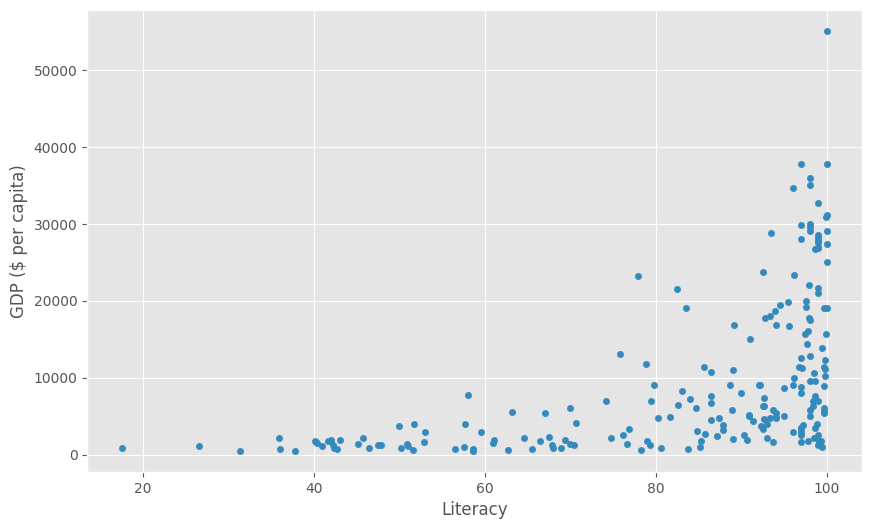

In [89]:
full_countries.toPandas().plot(x="Literacy",y="GDP ($ per capita)",kind="scatter",figsize=(10, 6))

# Useful information

 * https://spark.apache.org/docs/latest/quick-start.html
 * https://spark.apache.org/docs/latest/sql-programming-guide.html
 * https://pandas.pydata.org/pandas-docs/stable/visualization.html

# Homework

### Task 1

Narysuj wykres zależności kolumn Birthrate i Deathrate w zależności od GDP per capita dla 30 najbogatszych i 30 najbiedniejszych krajów.

In [105]:
countries_decimal = countries.select('Country', 'Birthrate', 'Deathrate', 'GDP ($ per capita)').na.drop()
countries_decimal = (countries_decimal
                      .withColumn("Birthrate_m", float_udf("Birthrate"))
                      .withColumn("Deathrate_m", float_udf("Deathrate"))
                      )

In [106]:
poorest = countries_decimal.select("Country", "Birthrate_m", "Deathrate_m", "GDP ($ per capita)").orderBy("GDP ($ per capita)", ascending=True).limit(30).toPandas()
poorest

,Country,Birthrate_m,Deathrate_m,GDP ($ per capita)
0,Sierra Leone,45.759998,23.030001,500
1,East Timor,26.990000,6.240000,500
2,Somalia,45.130001,16.629999,500
3,Burundi,42.220001,13.460000,600
4,Gaza Strip,39.450001,3.800000,600
5,Malawi,43.130001,19.330000,600
6,Tanzania,37.709999,16.389999,600
7,Comoros,36.930000,8.200000,700
8,"Congo, Dem. Rep.",43.689999,13.270000,700
9,"Congo, Repub. of the",42.570000,12.930000,700


In [108]:
richest = countries_decimal.select("Country", "Birthrate_m", "Deathrate_m", "GDP ($ per capita)").orderBy("GDP ($ per capita)", ascending=False).limit(30).toPandas()
richest

,Country,Birthrate_m,Deathrate_m,GDP ($ per capita)
0,Luxembourg,11.940000,8.41,55100
1,Norway,11.460000,9.40,37800
2,United States,14.140000,8.26,37800
3,Bermuda,11.400000,7.74,36000
4,Cayman Islands,12.740000,4.89,35000
5,San Marino,10.020000,8.17,34600
6,Switzerland,9.710000,8.49,32700
7,Denmark,11.130000,10.36,31100
8,Iceland,13.640000,6.72,30900
9,Austria,8.740000,9.76,30000


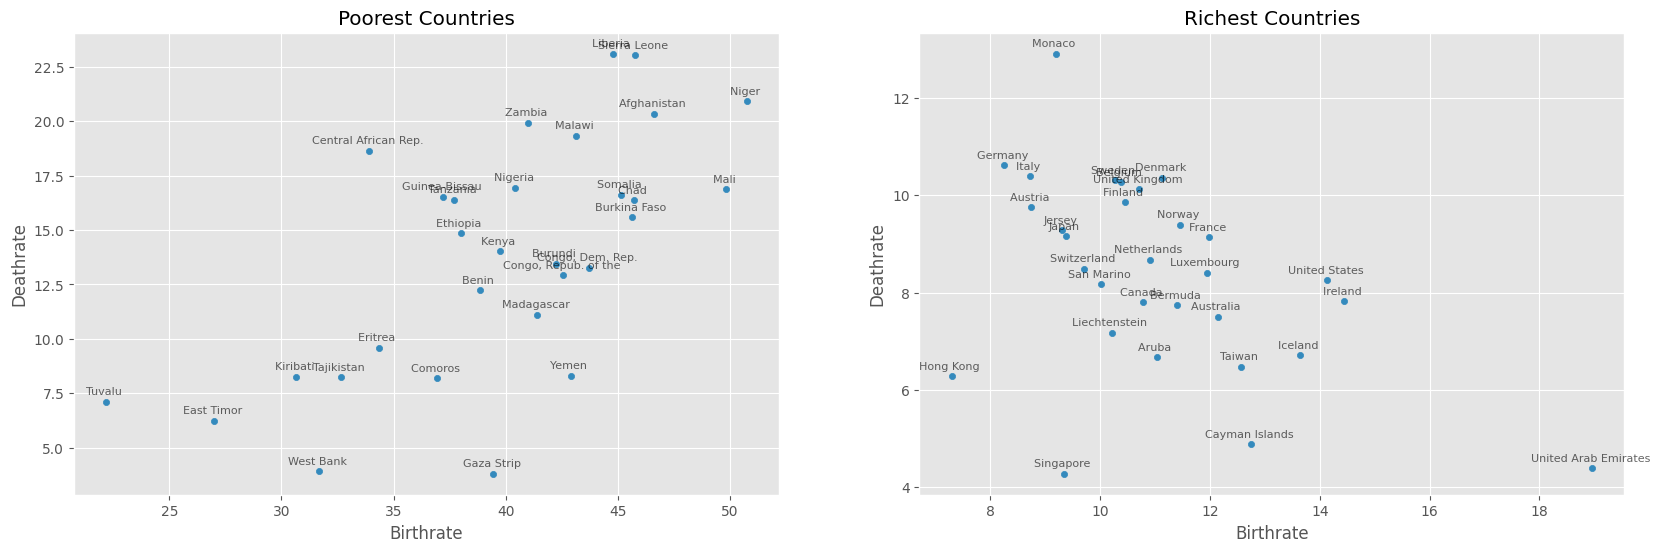

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))


poorest.plot(x='Birthrate_m', y='Deathrate_m',kind='scatter', ax=ax[0])
ax[0].set_title("Poorest Countries")
ax[0].set_xlabel("Birthrate")
ax[0].set_ylabel("Deathrate")

for i, row in poorest.iterrows():
    ax[0].annotate(row['Country'], (row['Birthrate_m'], row['Deathrate_m']),
                   textcoords="offset points", xytext=(0,5), ha='center', alpha=0.6, fontsize=8)

richest.plot(x='Birthrate_m', y='Deathrate_m',kind='scatter', ax=ax[1])
ax[1].set_title("Richest Countries")
ax[1].set_xlabel("Birthrate")
ax[1].set_ylabel("Deathrate")

for i, row in richest.iterrows():
    ax[1].annotate(row['Country'], (row['Birthrate_m'], row['Deathrate_m']),
                   textcoords="offset points", xytext=(0,5), ha='center', alpha=0.6, fontsize=8)

### Task 2

Wczytaj zbiór danych "airports.csv" ze strony https://www.kaggle.com/jonatancr/airports (zawiera on dane na temat lotnisk z całego świata). Ponieważ w zbiorze tym nie ma nagłówka, nadaj własne nazwy kolumnom, korzystając z opisu pliku na stronie OpenFlights: Airport and airline data. Narysuj na wykresie (mapie) położenia wszystkich/wybranych lotnisk.

In [167]:
file_path = "airports.csv"

airports = spark.read.csv(file_path,inferSchema=True, header=True)

print(airports.show(5))

+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+------------+--------------------+------------+-----------+
|AIRPORT_ID|        AIRPORT_NAME|        CITY|         COUNTRY|IATA|ICAO|          LATITUDE|         LONGITUDE|ALTITUDE|TIMEZONE|DST_DAYLIGHT|         TZ_DATABASE|AIRPORT_TYPE|     SOURCE|
+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+------------+--------------------+------------+-----------+
|         1|      Goroka Airport|      Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|     145.391998291|    5282|      10|           U|Pacific/Port_Moresby|     airport|OurAirports|
|         2|      Madang Airport|      Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|     145.789001465|      20|      10|           U|Pacific/Port_Moresby|     airport|OurAirports|
|         3|Mount Hagen Kagam...| Mount Hagen|Papua New

In [139]:
airports.printSchema()

root
 |-- AIRPORT_ID: integer (nullable = true)
 |-- AIRPORT_NAME: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ALTITUDE: integer (nullable = true)
 |-- TIMEZONE: string (nullable = true)
 |-- DST_DAYLIGHT: string (nullable = true)
 |-- TZ_DATABASE: string (nullable = true)
 |-- AIRPORT_TYPE: string (nullable = true)
 |-- SOURCE: string (nullable = true)



In [126]:
print(f"Liczba wierszy: {airports.count()}")

Liczba wierszy: 7184


In [131]:
pd.DataFrame.iteritems = pd.DataFrame.items

In [134]:
!pip install cartopy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.1 MB/s eta 0:00:00


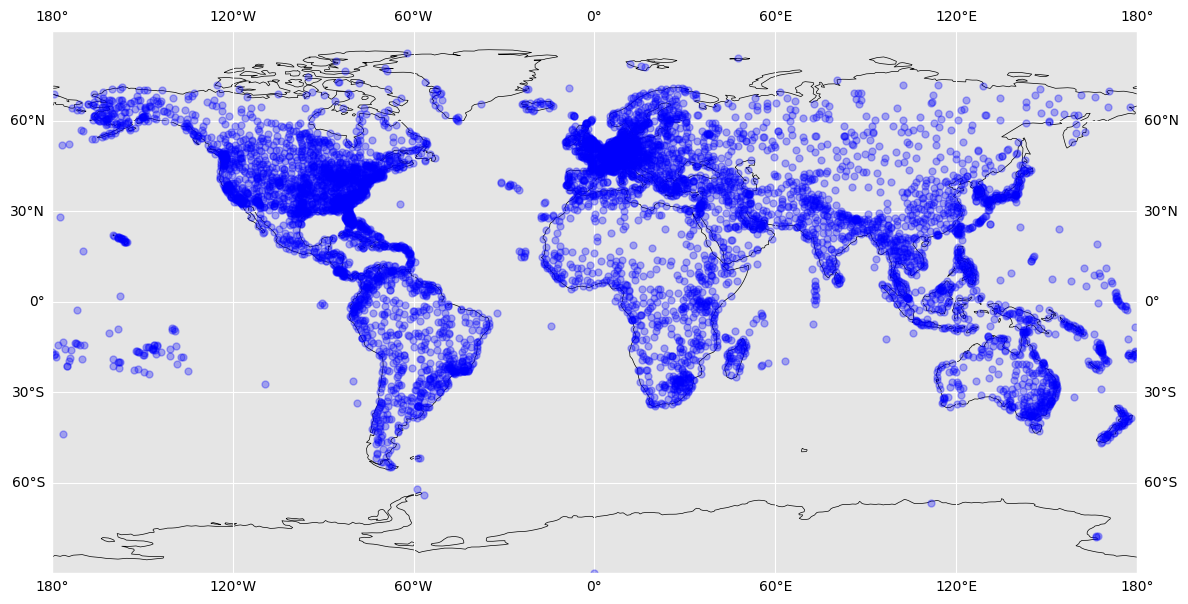

In [149]:
airports_pd = airports.toPandas()

fig = plt.figure(figsize=(14, 8))
# odwzorowanie kartograficzne
ax = plt.axes(projection=ccrs.PlateCarree())
# base mapa
ax.coastlines()
# linie siatki
ax.gridlines(draw_labels=True)

for index, row in airports_pd.iterrows():
    if pd.notnull(row['LATITUDE']) and pd.notnull(row['LONGITUDE']):
        ax.plot(row['LONGITUDE'], row['LATITUDE'], marker='o', color='blue', markersize=5, alpha=0.3, transform=ccrs.PlateCarree())

# Wyświetlenie mapy
plt.show()

### Task 3

Znajdź 10 krajów w których najniżej położone lotnisko ma najwyższą wysokość, podając wyniki w m. n. p. m.

In [165]:
def feet_to_meters(altitude):
  return altitude * 0.3048

feet_to_meters_udf = udf(feet_to_meters, FloatType())

airports = airports.withColumn("ALTITUDE_IN_METERS", feet_to_meters_udf("ALTITUDE"))

In [166]:
from pyspark.sql.functions import min

pd_airports = airports.select("COUNTRY", "ALTITUDE_IN_METERS").groupBy("COUNTRY").agg(min("ALTITUDE_IN_METERS").alias("MIN_ALTITUDE")).orderBy("MIN_ALTITUDE", ascending=False).limit(10).toPandas()
pd_airports

,COUNTRY,MIN_ALTITUDE
0,Lesotho,1556.004028
1,Rwanda,1481.023193
2,Burundi,786.993591
3,West Bank,757.427979
4,Uganda,753.465576
5,Swaziland,632.460022
6,Kyrgyzstan,627.278381
7,Botswana,540.105591
8,Malawi,481.584015
9,South Sudan,461.162415


### Task 4

Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju.
Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy.

In [168]:
countries.show(5)

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|   Afghanistan |ASIA (EX. NEAR EA...|  31056997|        647500|            

In [169]:
airports.show(5)

+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+------------+--------------------+------------+-----------+
|AIRPORT_ID|        AIRPORT_NAME|        CITY|         COUNTRY|IATA|ICAO|          LATITUDE|         LONGITUDE|ALTITUDE|TIMEZONE|DST_DAYLIGHT|         TZ_DATABASE|AIRPORT_TYPE|     SOURCE|
+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+------------+--------------------+------------+-----------+
|         1|      Goroka Airport|      Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|     145.391998291|    5282|      10|           U|Pacific/Port_Moresby|     airport|OurAirports|
|         2|      Madang Airport|      Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|     145.789001465|      20|      10|           U|Pacific/Port_Moresby|     airport|OurAirports|
|         3|Mount Hagen Kagam...| Mount Hagen|Papua New

In [205]:
from pyspark.sql.functions import count, trim

countries_reduced = countries.select("Country", "Population").withColumn("Country_trim", trim("Country"))

airport_reduced = airports.select("COUNTRY", "AIRPORT_ID").groupBy("COUNTRY").agg(count("AIRPORT_ID")).withColumnRenamed('COUNTRY', 'Airport_Country')

In [208]:
joined_inner = airport_reduced.join(countries_reduced, airport_reduced['Airport_Country'] == countries_reduced['Country_trim'], 'inner')

In [210]:
joined_inned_pd = joined_inner.select("Airport_Country", "count(AIRPORT_ID)", "Population") \
.withColumnRenamed('Airport_Country', 'Country') \
.withColumnRenamed("count(AIRPORT_ID)", 'Airports Count') \
.orderBy('Country').toPandas()

joined_inned_pd

,Country,Airports Count,Population
0,Afghanistan,20,31056997
1,Albania,5,3581655
2,Algeria,43,32930091
3,American Samoa,2,57794
4,Angola,24,12127071
...,...,...,...
200,West Bank,1,2460492
201,Western Sahara,3,273008
202,Yemen,11,21456188
203,Zambia,12,11502010


Text(0.5, 1.0, 'Population vs Airports Count')

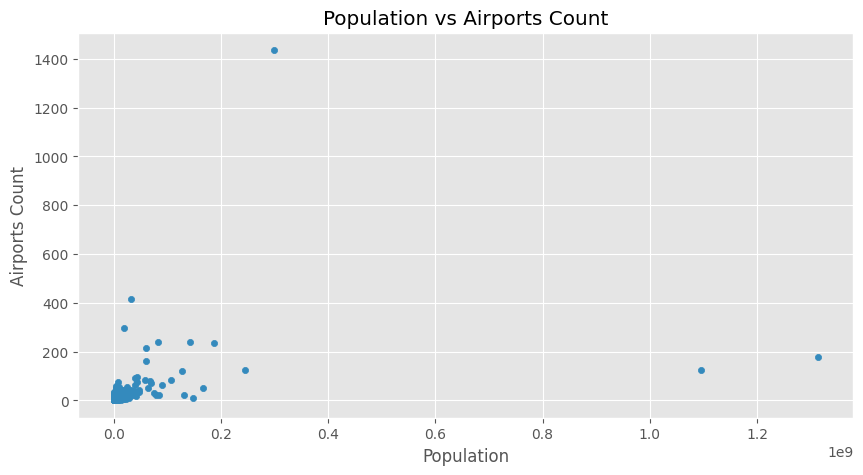

In [215]:
ax = joined_inned_pd.plot(x='Population', y='Airports Count',kind='scatter', figsize = (10,5))
ax.set_title("Population vs Airports Count")

In [217]:
# Nazwy, ltóre się nie pokrywają
joined_outer = airport_reduced.join(countries_reduced, airport_reduced['Airport_Country'] == countries_reduced['Country_trim'], 'outer')

joined_outer.show()

+--------------------+-----------------+--------------------+----------+--------------------+
|     Airport_Country|count(AIRPORT_ID)|             Country|Population|        Country_trim|
+--------------------+-----------------+--------------------+----------+--------------------+
|                Chad|                6|               Chad |   9944201|                Chad|
|                null|             null|Congo, Repub. of ...|   3702314|Congo, Repub. of the|
|            Anguilla|                1|           Anguilla |     13477|            Anguilla|
|            Paraguay|                8|           Paraguay |   6506464|            Paraguay|
|              Russia|              238|             Russia | 142893540|              Russia|
|British Indian Oc...|                1|                null|      null|                null|
|               Yemen|               11|              Yemen |  21456188|               Yemen|
|                null|             null|       Korea, North 

In [220]:
non_matching = joined_outer.filter((joined_outer['Airport_Country'].isNull()) | (joined_outer['Country_trim'].isNull()))

non_matching.show()

+--------------------+-----------------+--------------------+----------+--------------------+
|     Airport_Country|count(AIRPORT_ID)|             Country|Population|        Country_trim|
+--------------------+-----------------+--------------------+----------+--------------------+
|                null|             null|Congo, Repub. of ...|   3702314|Congo, Repub. of the|
|British Indian Oc...|                1|                null|      null|                null|
|                null|             null|       Korea, North |  23113019|        Korea, North|
|                null|             null|   Congo, Dem. Rep. |  62660551|    Congo, Dem. Rep.|
|      Norfolk Island|                1|                null|      null|                null|
|Northern Mariana ...|                3|                null|      null|                null|
|Turks and Caicos ...|                6|                null|      null|                null|
|                null|             null|Central African R...

In [221]:
print(f"Liczba krajów bez dopasowania w drugiej ramce: {non_matching.count()}")

Liczba krajów bez dopasowania w drugiej ramce: 54


In [226]:
airport_list = non_matching.select("Airport_Country").na.drop().rdd.flatMap(lambda x: x).collect()
countries_list = non_matching.select("Country_trim").na.drop().rdd.flatMap(lambda x: x).collect()

full_list = airport_list + countries_list

In [228]:
pd.DataFrame(full_list, columns=['Full list'])

,Full list
0,British Indian Ocean Territory
1,Norfolk Island
2,Northern Mariana Islands
3,Turks and Caicos Islands
4,British Virgin Islands
5,Myanmar
6,Bahamas
7,Sao Tome and Principe
8,Saint Pierre and Miquelon
9,Congo (Kinshasa)


### Task 5

Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie kołowym.

In [258]:
from pyspark.sql.functions import when

countries_w_continent = countries.withColumn(
    "Continent",
    when(col("Region").like("%EUROPE%"), "Europe")
    .when(col("Region").like("%BALTICS%"), "Europe")
    .when(col("Region").like("%C.W. OF IND. STATES%"), "Europe/Asia C.W of IND STATES")
    .when(col("Region").like("%ASIA%"), "Asia")
    .when(col("Region").like("%NEAR%EAST%"), "Asia")
    .when(col("Region").like("%AFRICA%"), "Africa")
    .when(col("Region").like("%AUSTRALIA%"), "Australia and Oceania")
    .when(col("Region").like("%OCEANIA%"), "Australia and Oceania")
    .when(col("Region").like("%NORTH%AMERICA%"), "North America")
    .when(col("Region").like("%SOUTH%AMERICA%"), "South America")
    .when(col("Region").like("%LATIN%AMER%"), "South America")
    .otherwise("Unknown")
    )

In [255]:
countries_w_continent.show(5)

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+--------------------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|           Continent|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+--------------------+
|   Afghanist

In [259]:
countries_reduced = countries_w_continent.select("Country", "Continent").withColumn("Country_trim", trim("Country"))


joined = airport_reduced.join(countries_reduced, airport_reduced['Airport_Country'] == countries_reduced['Country_trim'], 'inner')

In [262]:
joined_inner = joined.select("Airport_Country", "count(AIRPORT_ID)", "Continent") \
.withColumnRenamed('Airport_Country', 'Country') \
.withColumnRenamed("count(AIRPORT_ID)", 'Airports Count') \
.orderBy('Country')

joined_inner.show()

+--------------+--------------+--------------------+
|       Country|Airports Count|           Continent|
+--------------+--------------+--------------------+
|   Afghanistan|            20|                Asia|
|       Albania|             5|              Europe|
|       Algeria|            43|              Africa|
|American Samoa|             2|Australia and Oce...|
|        Angola|            24|              Africa|
|      Anguilla|             1|       South America|
|     Argentina|            94|       South America|
|       Armenia|             5|Europe/Asia C.W o...|
|         Aruba|             1|       South America|
|     Australia|           296|Australia and Oce...|
|       Austria|            19|              Europe|
|    Azerbaijan|             7|Europe/Asia C.W o...|
|       Bahrain|             2|                Asia|
|    Bangladesh|            10|                Asia|
|      Barbados|             1|       South America|
|       Belarus|            10|Europe/Asia C.W

In [266]:
joined_df = joined_inner.groupBy("Continent").agg(sum("Airports Count").alias("Airports Count")).toPandas()
joined_df

,Continent,Airports Count
0,Australia and Oceania,542
1,Europe,1391
2,Africa,655
3,North America,1875
4,South America,921
5,Europe/Asia C.W of IND STATES,357
6,Asia,1272


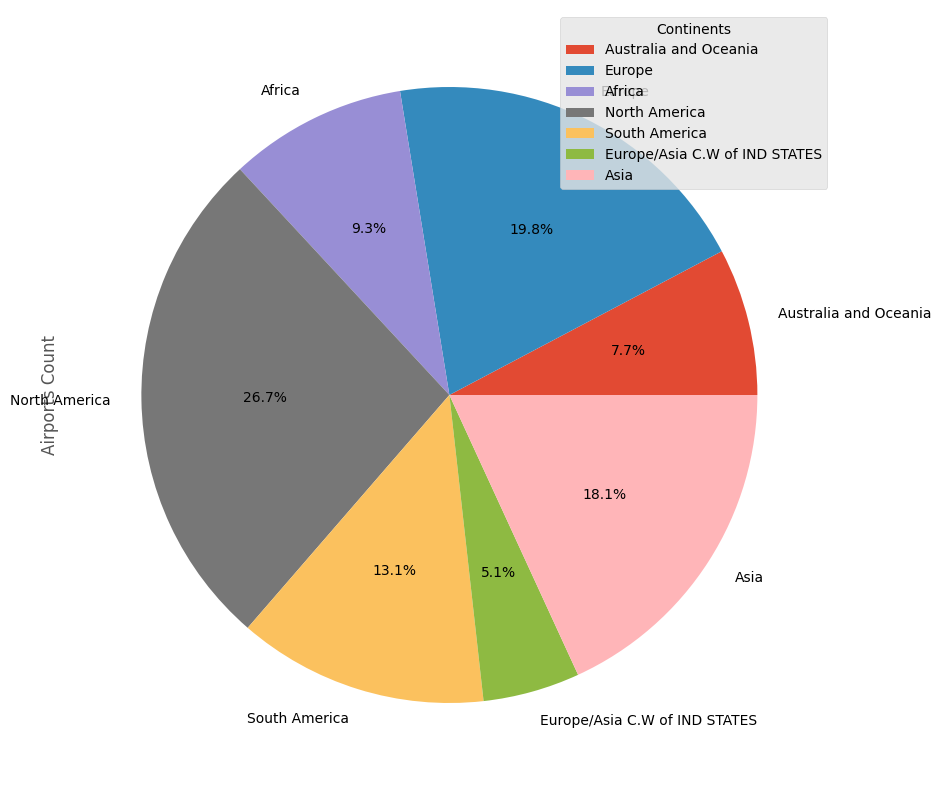

In [267]:
joined_df.set_index('Continent', inplace=True)

joined_df.plot.pie(y = 'Airports Count',  autopct='%1.1f%%', figsize = (10, 10))
plt.legend(title="Continents", labels=joined_df.index)